

| Pathway | What it does | Implementation |
|---------|--------------|----------------|
| **X** | Local contrast (center-surround) | `3×3 Conv` - `1×1 Conv` |
| **Y** | Large RF contrast | `5×5 Dilated Conv` - `1×1 Conv` |
| **W** | Directional | `1×3 Conv` (horizontal) + `3×1 Conv` (vertical) |

**W pathway is NOT Gabor filters** - it's separable directional convolutions.

**Gabor filters** are specifically oriented edge detectors with sinusoidal patterns at different angles (0°, 45°, 90°, 135°, etc.). They're biologically inspired by V1 cortex cells.



In [2]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.metrics import precision_recall_curve, average_precision_score
import os
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [3]:
os.listdir("/kaggle/input/hed-bsds-v2/processed_HED_v2")


['test', 'train']

In [8]:
os.listdir("/kaggle/input/12epoch/pytorch/default/1")


['12epoch.pth']

In [9]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))
print("Total VRAM (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2))


CUDA available: True
GPU name: Tesla T4
Total VRAM (GB): 14.74


In [10]:
import os

BASE = "/kaggle/input/hed-bsds-v2/processed_HED_v2"

print("ROOT:", os.listdir(BASE))
print("TRAIN:", os.listdir(BASE + "/train"))
print("TRAIN/IMAGES:", os.listdir(BASE + "/train/images")[:10])
print("TRAIN/EDGES:", os.listdir(BASE + "/train/edges")[:10])


ROOT: ['test', 'train']
TRAIN: ['edges', 'images']
TRAIN/IMAGES: ['hedbsds_train_007314.png', 'hedbsds_train_003491.png', 'hedbsds_train_005324.png', 'hedbsds_train_001683.png', 'hedbsds_train_003120.png', 'hedbsds_train_002305.png', 'hedbsds_train_003996.png', 'hedbsds_train_002197.png', 'hedbsds_train_006447.png', 'hedbsds_train_007116.png']
TRAIN/EDGES: ['hedbsds_train_007314.png', 'hedbsds_train_003491.png', 'hedbsds_train_005324.png', 'hedbsds_train_001683.png', 'hedbsds_train_003120.png', 'hedbsds_train_002305.png', 'hedbsds_train_003996.png', 'hedbsds_train_002197.png', 'hedbsds_train_006447.png', 'hedbsds_train_007116.png']


In [1]:
import cv2
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm

def verify_edges(root_dir, split="train"):
    root_dir = Path(root_dir)
    img_dir = root_dir / split / "images"
    edge_dir = root_dir / split / "edges"

    image_files = sorted(list(img_dir.glob("*.png")))

    missing_edges = []
    unreadable_edges = []
    empty_edges = []
    size_mismatch = []

    print(f"\nVerifying split: {split}")
    print("=" * 60)

    for img_path in tqdm(image_files, desc=f"Checking {split}", unit="img"):
        edge_path = edge_dir / img_path.name

        # 1. Check if edge file exists
        if not edge_path.exists():
            missing_edges.append(img_path.name)
            continue

        # 2. Try loading edge
        edge = cv2.imread(str(edge_path), cv2.IMREAD_GRAYSCALE)
        if edge is None:
            unreadable_edges.append(img_path.name)
            continue

        # 3. Check if edge is empty (all zeros)
        if np.sum(edge) == 0:
            empty_edges.append(img_path.name)

        # 4. Check size match
        img = cv2.imread(str(img_path))
        if img is None or edge.shape != img.shape[:2]:
            size_mismatch.append(img_path.name)

    # ===== REPORT =====
    print(f"\nVerification Report for split: {split}")
    print("=" * 60)
    print(f"Total images checked: {len(image_files)}")
    print(f"Missing edge files: {len(missing_edges)}")
    print(f"Unreadable edge files: {len(unreadable_edges)}")
    print(f"Empty edge maps: {len(empty_edges)}")
    print(f"Size mismatches: {len(size_mismatch)}")

    if missing_edges:
        print("\nMissing edge files (first 10):")
        print(missing_edges[:10])

    if unreadable_edges:
        print("\nUnreadable edge files (first 10):")
        print(unreadable_edges[:10])

    if empty_edges:
        print("\nEmpty edge maps (first 10):")
        print(empty_edges[:10])

    if size_mismatch:
        print("\nSize mismatches (first 10):")
        print(size_mismatch[:10])

    if not (missing_edges or unreadable_edges or empty_edges or size_mismatch):
        print("\nAll images have valid, non-empty, correctly-sized edge maps.")

# =========================
# RUN FOR ALL SPLITS
# =========================

DATA_ROOT = r"/kaggle/input/hed-bsds-v2/processed_HED_v2"

verify_edges(DATA_ROOT, "train")
verify_edges(DATA_ROOT, "val")
verify_edges(DATA_ROOT, "test")



Verifying split: train


Checking train: 100%|██████████| 9600/9600 [03:33<00:00, 44.87img/s]



Verification Report for split: train
Total images checked: 9600
Missing edge files: 0
Unreadable edge files: 0
Empty edge maps: 0
Size mismatches: 0

All images have valid, non-empty, correctly-sized edge maps.

Verifying split: val


Checking val: 0img [00:00, ?img/s]



Verification Report for split: val
Total images checked: 0
Missing edge files: 0
Unreadable edge files: 0
Empty edge maps: 0
Size mismatches: 0

All images have valid, non-empty, correctly-sized edge maps.

Verifying split: test


Checking test: 100%|██████████| 200/200 [00:04<00:00, 45.96img/s]


Verification Report for split: test
Total images checked: 200
Missing edge files: 0
Unreadable edge files: 0
Empty edge maps: 0
Size mismatches: 0

All images have valid, non-empty, correctly-sized edge maps.


In [11]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
import numpy as np

# Cell 2: Dataset Loader
class ProcessedDataset(Dataset):
    """Load processed PNG images and edge maps"""

    def __init__(self, root_dir, split='train'):
        self.root_dir = Path(root_dir)
        self.split = split
        self.img_dir = self.root_dir / split / 'images'
        self.edge_dir = self.root_dir / split / 'edges'
        self.samples = sorted(list(self.img_dir.glob('*.png')))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        edge_path = self.edge_dir / img_path.name

        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0

        # Load edge map
        edge = cv2.imread(str(edge_path), cv2.IMREAD_GRAYSCALE)
        edge = edge.astype(np.float32) / 255.0

        # To tensors
        img = torch.from_numpy(img).permute(2, 0, 1)
        edge = torch.from_numpy(edge).unsqueeze(0)

        return {'images': img, 'labels': edge, 'filename': img_path.stem}


# ✅ KAGGLE DATASET ROOT
DATA_ROOT = "/kaggle/input/hed-bsds-v2/processed_HED_v2"

BATCH_SIZE = 4

train_dataset = ProcessedDataset(DATA_ROOT, split='train')
# val_dataset   = ProcessedDataset(DATA_ROOT, split='val')
val_dataset   = ProcessedDataset(DATA_ROOT, split='test')

test_dataset  = ProcessedDataset(DATA_ROOT, split='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} samples")
print(f"Val:   {len(val_dataset)} samples")
print(f"Test:  {len(test_dataset)} samples")

# Verify sample
sample = train_dataset[0]
print("Image shape:", sample["images"].shape)
print("Edge shape:", sample["labels"].shape)


Train: 9600 samples
Val:   200 samples
Test:  200 samples
Image shape: torch.Size([3, 512, 512])
Edge shape: torch.Size([1, 512, 512])


In [12]:
# Cell 3: XYW-Net Model (Complete)

# ============ PDC Convolution ============
def createPDCFunc(PDC_type):
    """Create Pixel Difference Convolution function"""
    assert PDC_type in ['cv', 'cd', 'ad', 'rd', 'sd', 'p2d', '2sd', '2cd']
    
    if PDC_type == 'cv':
        return F.conv2d
    
    if PDC_type == '2sd':
        def func(x, weights, bias=None, stride=1, padding=0, dilation=1, groups=1):
            assert weights.size(2) == 3 and weights.size(3) == 3
            shape = weights.shape
            if groups == shape[0]:
                weights_conv = (weights - weights[:, :, [1, 1, 1, 0, 0, 0, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]].view(shape))
            else:
                weights_conv = (weights - weights[:, :, [1, 1, 1, 0, 0, 0, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]].view(shape).flip(0))
            y = F.conv2d(x, weights_conv, bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
            return y
        return func
    
    return F.conv2d

class Conv2d(nn.Module):
    """PDC-enabled Conv2d"""
    def __init__(self, pdc_func='cv', in_channels=1, out_channels=1, kernel_size=3, 
                 stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(Conv2d, self).__init__()
        self.pdc = createPDCFunc(pdc_func)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, kernel_size, kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        return self.pdc(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

# ============ Core XYW Components ============
class Xc1x1(nn.Module):
    """X pathway: Local contrast (center-surround with 3x3)"""
    def __init__(self, in_channels, out_channels):
        super(Xc1x1, self).__init__()
        self.Xcenter = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.Xcenter_relu = nn.ReLU(inplace=True)
        self.Xsurround = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, groups=in_channels)
        self.conv1_1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.Xsurround_relu = nn.ReLU(inplace=True)

    def forward(self, input):
        xcenter = self.Xcenter_relu(self.Xcenter(input))
        xsurround = self.Xsurround_relu(self.Xsurround(input))
        xsurround = self.conv1_1(xsurround)
        return xsurround - xcenter

class Yc1x1(nn.Module):
    """Y pathway: Large receptive field (center-surround with 5x5 dilated)"""
    def __init__(self, in_channels, out_channels):
        super(Yc1x1, self).__init__()
        self.Ycenter = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.Ycenter_relu = nn.ReLU(inplace=True)
        self.Ysurround = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=4, dilation=2, groups=in_channels)
        self.conv1_1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.Ysurround_relu = nn.ReLU(inplace=True)

    def forward(self, input):
        ycenter = self.Ycenter_relu(self.Ycenter(input))
        ysurround = self.Ysurround_relu(self.Ysurround(input))
        ysurround = self.conv1_1(ysurround)
        return ysurround - ycenter

class W(nn.Module):
    """W pathway: Directional (horizontal + vertical)"""
    def __init__(self, inchannel, outchannel):
        super(W, self).__init__()
        self.h = nn.Conv2d(inchannel, inchannel, kernel_size=(1, 3), padding=(0, 1), groups=inchannel)
        self.v = nn.Conv2d(inchannel, inchannel, kernel_size=(3, 1), padding=(1, 0), groups=inchannel)
        self.convh_1 = nn.Conv2d(inchannel, inchannel, kernel_size=1, bias=False)
        self.convv_1 = nn.Conv2d(inchannel, outchannel, kernel_size=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.h(x))
        h = self.convh_1(h)
        v = self.relu(self.v(h))
        v = self.convv_1(v)
        return v

# ============ XYW Blocks ============
class XYW_S(nn.Module):
    """XYW Start block"""
    def __init__(self, inchannel, outchannel, stride=1):
        super(XYW_S, self).__init__()
        self.y_c = Yc1x1(inchannel, outchannel)
        self.x_c = Xc1x1(inchannel, outchannel)
        self.w = W(inchannel, outchannel)

    def forward(self, x):
        return self.x_c(x), self.y_c(x), self.w(x)

class XYW(nn.Module):
    """XYW middle block"""
    def __init__(self, inchannel, outchannel, stride=1):
        super(XYW, self).__init__()
        self.y_c = Yc1x1(inchannel, outchannel)
        self.x_c = Xc1x1(inchannel, outchannel)
        self.w = W(inchannel, outchannel)

    def forward(self, xc, yc, w):
        return self.x_c(xc), self.y_c(yc), self.w(w)

class XYW_E(nn.Module):
    """XYW End block (combines X+Y+W)"""
    def __init__(self, inchannel, outchannel):
        super(XYW_E, self).__init__()
        self.y_c = Yc1x1(inchannel, outchannel)
        self.x_c = Xc1x1(inchannel, outchannel)
        self.w = W(inchannel, outchannel)

    def forward(self, xc, yc, w):
        return self.x_c(xc) + self.y_c(yc) + self.w(w)

# ============ Encoder Stages ============
class s1(nn.Module):
    def __init__(self, channel=30):
        super(s1, self).__init__()
        self.conv1 = nn.Conv2d(3, channel, kernel_size=7, padding=6, dilation=2)
        self.xyw1_1 = XYW_S(channel, channel)
        self.xyw1_2 = XYW(channel, channel)
        self.xyw1_3 = XYW_E(channel, channel)
        self.relu = nn.ReLU()

    def forward(self, x):
        temp = self.relu(self.conv1(x))
        xc, yc, w = self.xyw1_1(temp)
        xc, yc, w = self.xyw1_2(xc, yc, w)
        xyw1_3 = self.xyw1_3(xc, yc, w)
        return xyw1_3 + temp

class s2(nn.Module):
    def __init__(self, channel=60):
        super(s2, self).__init__()
        self.xyw2_1 = XYW_S(channel//2, channel, stride=2)
        self.xyw2_2 = XYW(channel, channel)
        self.xyw2_3 = XYW_E(channel, channel)
        self.shortcut = nn.Conv2d(channel//2, channel, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(x)
        xc, yc, w = self.xyw2_1(x)
        xc, yc, w = self.xyw2_2(xc, yc, w)
        xyw2_3 = self.xyw2_3(xc, yc, w)
        return xyw2_3 + self.shortcut(x)

class s3(nn.Module):
    def __init__(self, channel=120):
        super(s3, self).__init__()
        self.xyw3_1 = XYW_S(channel//2, channel, stride=2)
        self.xyw3_2 = XYW(channel, channel)
        self.xyw3_3 = XYW_E(channel, channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.shortcut = nn.Conv2d(channel//2, channel, kernel_size=1)

    def forward(self, x):
        x = self.pool(x)
        shortcut = self.shortcut(x)
        xc, yc, w = self.xyw3_1(x)
        xc, yc, w = self.xyw3_2(xc, yc, w)
        xyw3_3 = self.xyw3_3(xc, yc, w)
        return xyw3_3 + shortcut

class s4(nn.Module):
    def __init__(self, channel=120):
        super(s4, self).__init__()
        self.xyw4_1 = XYW_S(channel, channel, stride=2)
        self.xyw4_2 = XYW(channel, channel)
        self.xyw4_3 = XYW_E(channel, channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.shortcut = nn.Conv2d(channel, channel, kernel_size=1)

    def forward(self, x):
        x = self.pool(x)
        shortcut = self.shortcut(x)
        xc, yc, w = self.xyw4_1(x)
        xc, yc, w = self.xyw4_2(xc, yc, w)
        xyw4_3 = self.xyw4_3(xc, yc, w)
        return xyw4_3 + shortcut

# ============ Encoder ============
class encode(nn.Module):
    def __init__(self):
        super(encode, self).__init__()
        self.s1 = s1()
        self.s2 = s2()
        self.s3 = s3()
        self.s4 = s4()

    def forward(self, x):
        s1_out = self.s1(x)
        s2_out = self.s2(s1_out)
        s3_out = self.s3(s2_out)
        s4_out = self.s4(s3_out)
        return s1_out, s2_out, s3_out, s4_out

# ============ Adaptive Convolution ============
def upsample_filt(size):
    factor = (size + 1) // 2
    center = factor - 1 if size % 2 == 1 else factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)

def bilinear_upsample_weights(factor, num_classes):
    filter_size = 2 * factor - factor % 2
    weights = np.zeros((num_classes, num_classes, filter_size, filter_size), dtype=np.float32)
    upsample_kernel = upsample_filt(filter_size)
    for i in range(num_classes):
        weights[i, i, :, :] = upsample_kernel
    return torch.Tensor(weights)

class adap_conv(nn.Module):
    """Adaptive convolution with learnable weight"""
    def __init__(self, in_channels, out_channels, kz=3, pd=1):
        super(adap_conv, self).__init__()
        self.conv = nn.Sequential(
            Conv2d(pdc_func='2sd', in_channels=in_channels, out_channels=out_channels, kernel_size=kz, padding=pd),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.weight = nn.Parameter(torch.Tensor([0.]))

    def forward(self, x):
        return self.conv(x) * self.weight.sigmoid()

class Refine_block2_1(nn.Module):
    """Refinement block for decoder"""
    def __init__(self, in_channel, out_channel, factor, require_grad=False):
        super(Refine_block2_1, self).__init__()
        self.pre_conv1 = adap_conv(in_channel[0], out_channel, kz=3, pd=1)
        self.pre_conv2 = adap_conv(in_channel[1], out_channel, kz=3, pd=1)
        self.factor = factor
        self.deconv_weight = nn.Parameter(bilinear_upsample_weights(factor, out_channel), requires_grad=require_grad)

    def forward(self, *input):
        x1 = self.pre_conv1(input[0])
        x2 = self.pre_conv2(input[1])
        x2 = F.conv_transpose2d(x2, self.deconv_weight, stride=self.factor, 
                                padding=int(self.factor/2),
                                output_padding=(x1.size(2) - x2.size(2)*self.factor, 
                                               x1.size(3) - x2.size(3)*self.factor))
        return x1 + x2

# ============ RCF Decoder ============
class decode_rcf(nn.Module):
    def __init__(self):
        super(decode_rcf, self).__init__()
        self.f43 = Refine_block2_1(in_channel=(120, 120), out_channel=60, factor=2)
        self.f32 = Refine_block2_1(in_channel=(60, 60), out_channel=30, factor=2)
        self.f21 = Refine_block2_1(in_channel=(30, 30), out_channel=24, factor=2)
        self.f = nn.Conv2d(24, 1, kernel_size=1, padding=0)

    def forward(self, x):
        s3 = self.f43(x[2], x[3])
        s2 = self.f32(x[1], s3)
        s1 = self.f21(x[0], s2)
        out = self.f(s1)
        return out.sigmoid()

# ============ Full XYW-Net ============
class XYWNet(nn.Module):
    def __init__(self):
        super(XYWNet, self).__init__()
        self.encode = encode()
        self.decode = decode_rcf()

    def forward(self, x):
        endpoints = self.encode(x)
        out = self.decode(endpoints)
        return out
    
    def forward_with_stages(self, x):
        """Forward pass returning intermediate stage outputs for visualization"""
        s1, s2, s3, s4 = self.encode(x)
        final = self.decode((s1, s2, s3, s4))
        return final, (s1, s2, s3, s4)

# Create model
model = XYWNet().to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 890,275 parameters


In [13]:
# Cell 4: Loss Function and Metrics

class EdgeLoss(nn.Module):
    """Weighted cross-entropy loss for edge detection"""
    def __init__(self):
        super(EdgeLoss, self).__init__()
    
    def forward(self, pred, label):
        pred_flat = pred.view(-1)
        label_flat = label.view(-1)
        eps = 1e-6
        
        # Positive and negative pixels
        pos_mask = label_flat > 0
        neg_mask = label_flat == 0
        
        pred_pos = pred_flat[pos_mask].clamp(eps, 1.0 - eps)
        pred_neg = pred_flat[neg_mask].clamp(eps, 1.0 - eps)
        
        # Weighted by annotation strength
        w_pos = label_flat[pos_mask]
        
        if len(pred_pos) > 0 and len(pred_neg) > 0:
            loss = (-pred_pos.log() * w_pos).mean() + (-(1.0 - pred_neg).log()).mean()
        elif len(pred_pos) > 0:
            loss = (-pred_pos.log() * w_pos).mean()
        else:
            loss = (-(1.0 - pred_neg).log()).mean()
        
        return loss

def compute_ods_ois_ap(preds, labels, thresholds=99):
    """
    Compute ODS (Optimal Dataset Scale), OIS (Optimal Image Scale), and AP.
    
    ODS: Best F-score using a single threshold for all images
    OIS: Average of best F-score per image
    AP: Average Precision
    """
    threshs = np.linspace(0.01, 0.99, thresholds)
    
    # For ODS (global)
    all_preds = []
    all_labels = []
    
    # For OIS (per-image best)
    ois_f1_scores = []
    
    for pred, label in zip(preds, labels):
        pred_np = pred.flatten()
        label_np = (label.flatten() > 0.5).astype(np.float32)
        
        all_preds.append(pred_np)
        all_labels.append(label_np)
        
        # Per-image best F1
        best_f1 = 0
        for t in threshs:
            pred_bin = (pred_np >= t).astype(np.float32)
            tp = np.sum(pred_bin * label_np)
            fp = np.sum(pred_bin * (1 - label_np))
            fn = np.sum((1 - pred_bin) * label_np)
            
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)
            best_f1 = max(best_f1, f1)
        
        ois_f1_scores.append(best_f1)
    
    # Concatenate all for global metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # ODS: Best global threshold
    best_ods = 0
    for t in threshs:
        pred_bin = (all_preds >= t).astype(np.float32)
        tp = np.sum(pred_bin * all_labels)
        fp = np.sum(pred_bin * (1 - all_labels))
        fn = np.sum((1 - pred_bin) * all_labels)
        
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        best_ods = max(best_ods, f1)
    
    # OIS: Average of per-image best
    ois = np.mean(ois_f1_scores)
    
    # AP: Average Precision
    try:
        ap = average_precision_score(all_labels, all_preds)
    except:
        ap = 0.0
    
    return best_ods, ois, ap

print("Loss function and metrics defined.")

Loss function and metrics defined.


In [14]:
# Cell 5: Training Function

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc='Training')
    for batch in pbar:
        images = batch['images'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc='Evaluating'):
        images = batch['images'].to(device)
        labels = batch['labels']
        
        outputs = model(images)
        
        for i in range(outputs.shape[0]):
            all_preds.append(outputs[i, 0].cpu().numpy())
            all_labels.append(labels[i, 0].numpy())
    
    ods, ois, ap = compute_ods_ois_ap(all_preds, all_labels)
    return ods, ois, ap

print("Training functions defined.")

Training functions defined.


In [33]:
# Cell 6: Train XYW-Net

# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# Initialize
model = XYWNet().to(device)
criterion = EdgeLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training history
history = {'train_loss': [], 'val_ods': [], 'val_ois': [], 'val_ap': []}
best_ods = 0

print(f"Training XYW-Net for {NUM_EPOCHS} epochs...")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    
    # Evaluate on validation
    val_ods, val_ois, val_ap = evaluate(model, val_loader, device)
    history['val_ods'].append(val_ods)
    history['val_ois'].append(val_ois)
    history['val_ap'].append(val_ap)
    
    scheduler.step()
    
    print(f"Loss: {train_loss:.4f} | ODS: {val_ods:.4f} | OIS: {val_ois:.4f} | AP: {val_ap:.4f}")
    
    # Save best model
    if val_ods > best_ods:
        best_ods = val_ods
        torch.save(model.state_dict(), 'best_xyw_net.pth')
        # torch.save({
        #     "epoch": epoch,
        #     "model_state": model.state_dict(),
        #     "optimizer_state": optimizer.state_dict(),
        #     "loss": loss
        # }, "checkpoint.pth")

        print(f"  -> Saved best model (ODS: {best_ods:.4f})")

print("\n" + "="*60)
print(f"Training complete. Best ODS: {best_ods:.4f}")

Training XYW-Net for 20 epochs...
Train samples: 9600, Val samples: 200

Epoch 1/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Loss: 0.4926 | ODS: 0.1367 | OIS: 0.1412 | AP: 0.0672
  -> Saved best model (ODS: 0.1367)

Epoch 2/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Loss: 0.3292 | ODS: 0.1541 | OIS: 0.1575 | AP: 0.0791
  -> Saved best model (ODS: 0.1541)

Epoch 3/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Loss: 0.3057 | ODS: 0.1631 | OIS: 0.1644 | AP: 0.0852
  -> Saved best model (ODS: 0.1631)

Epoch 4/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Loss: 0.2988 | ODS: 0.1574 | OIS: 0.1622 | AP: 0.0821

Epoch 5/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Loss: 0.2946 | ODS: 0.1630 | OIS: 0.1668 | AP: 0.0874

Epoch 6/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Loss: 0.2918 | ODS: 0.1622 | OIS: 0.1631 | AP: 0.0858

Epoch 7/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Loss: 0.2895 | ODS: 0.1569 | OIS: 0.1604 | AP: 0.0837

Epoch 8/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Loss: 0.2876 | ODS: 0.1736 | OIS: 0.1758 | AP: 0.0962
  -> Saved best model (ODS: 0.1736)

Epoch 9/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Loss: 0.2863 | ODS: 0.1700 | OIS: 0.1720 | AP: 0.0922

Epoch 10/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Loss: 0.2851 | ODS: 0.1639 | OIS: 0.1653 | AP: 0.0877

Epoch 11/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Loss: 0.2809 | ODS: 0.1696 | OIS: 0.1715 | AP: 0.0921

Epoch 12/20


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Loss: 0.2795 | ODS: 0.1721 | OIS: 0.1728 | AP: 0.0943

Epoch 13/20


Training:  22%|██▏       | 539/2400 [06:59<24:10,  1.28it/s, loss=0.2336]


KeyboardInterrupt: 

In [1]:
# Cell 6: Train XYW-Net (RESUME + FULL CHECKPOINT + PT EXPORT)

# -------------------------------
# Hyperparameters
# -------------------------------
NUM_EPOCHS = 30          # Total epochs you want after resume
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# -------------------------------
# Initialize
# -------------------------------
model = XYWNet().to(device)
criterion = EdgeLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# -------------------------------
#  RESUME FROM STATE_DICT (19 EPOCHS DONE)
# -------------------------------
start_epoch = 19  # You already trained 19 epochs

print("Loading pretrained weights from 20epoch.pth ...")
model.load_state_dict(torch.load("/kaggle/input/20epoch/pytorch/default/1/20epoch.pth", map_location=device))

print(f"Resuming training from epoch {start_epoch+1}")

# -------------------------------
# Training history
# -------------------------------
history = {'train_loss': [], 'val_ods': [], 'val_ois': [], 'val_ap': []}
best_ods = 0

print(f"Training XYW-Net for {NUM_EPOCHS} total epochs...")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print("=" * 60)

# -------------------------------
#  FULL CHECKPOINT SAVE FUNCTION
# -------------------------------
def save_checkpoint(model, optimizer, scheduler, epoch, best_ods, path):
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_ods": best_ods
    }, path)

# -------------------------------
#  TRAINING LOOP
# -------------------------------
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    
    # Evaluate
    val_ods, val_ois, val_ap = evaluate(model, val_loader, device)
    history['val_ods'].append(val_ods)
    history['val_ois'].append(val_ois)
    history['val_ap'].append(val_ap)
    
    scheduler.step()
    
    print(f"Loss: {train_loss:.4f} | ODS: {val_ods:.4f} | OIS: {val_ois:.4f} | AP: {val_ap:.4f}")
    
    

    #  SAVE BEST MODEL (STATE_DICT)
    if val_ods > best_ods: 
        best_ods = val_ods
        torch.save(model.state_dict(), "best_xyw_net.pth")
        print(f"  -> Saved best model (ODS: {best_ods:.4f})")
        print("------------")
        #  SAVE FULL CHECKPOINT EVERY EPOCH
        save_checkpoint(
            model,
            optimizer,
            scheduler,
            epoch,
            best_ods,
            "xywnet_full_checkpoint.pth"
        )
        # -------------------------------
        #  EXPORT DEPLOYMENT .pt MODEL
        # -------------------------------

        # traced_model = torch.jit.trace(model, example_input)
        # traced_model.save("xywnet_full_model.pt")



print("\n" + "=" * 60)
print(f"Training complete. Best ODS: {best_ods:.4f}")
print("Deployment model saved as: xywnet_deploy.pt")


NameError: name 'XYWNet' is not defined

In [ ]:
# Load model weights only
model.load_state_dict(torch.load("/kaggle/input/20epoch/pytorch/default/1/20epoch.pth", map_location=device))

# Recreate optimizer (state is reset)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

start_epoch = 12   # You already finished 12 epochs

for epoch in range(start_epoch, 50):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f}")


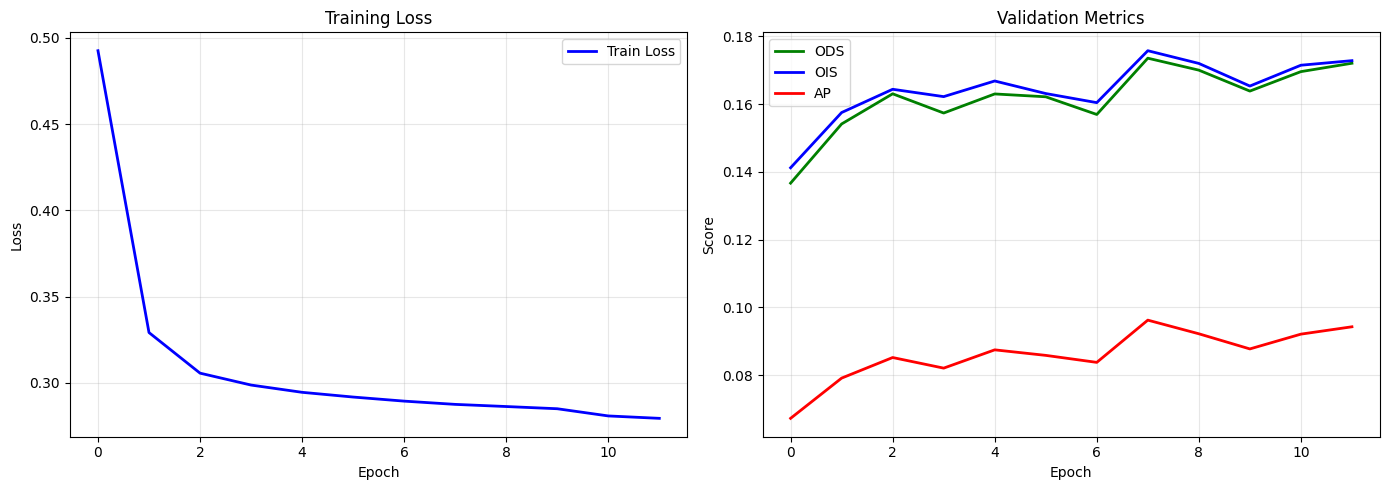

In [34]:
# Cell 7: Plot Training History

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], 'b-', linewidth=2, label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics
axes[1].plot(history['val_ods'], 'g-', linewidth=2, label='ODS')
axes[1].plot(history['val_ois'], 'b-', linewidth=2, label='OIS')
axes[1].plot(history['val_ap'], 'r-', linewidth=2, label='AP')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [35]:
# Cell 8: Final Test Evaluation

# Load best model
model.load_state_dict(torch.load('best_xyw_net.pth'))
print("Loaded best model weights.\n")

# Evaluate on test set
print("Evaluating on TEST set...")
test_ods, test_ois, test_ap = evaluate(model, test_loader, device)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
print(f"  ODS (Optimal Dataset Scale): {test_ods:.4f}")
print(f"  OIS (Optimal Image Scale):   {test_ois:.4f}")
print(f"  AP (Average Precision):      {test_ap:.4f}")
print("="*60)

Loaded best model weights.

Evaluating on TEST set...


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  4.09it/s]



FINAL TEST RESULTS
  ODS (Optimal Dataset Scale): 0.1736
  OIS (Optimal Image Scale):   0.1758
  AP (Average Precision):      0.0962


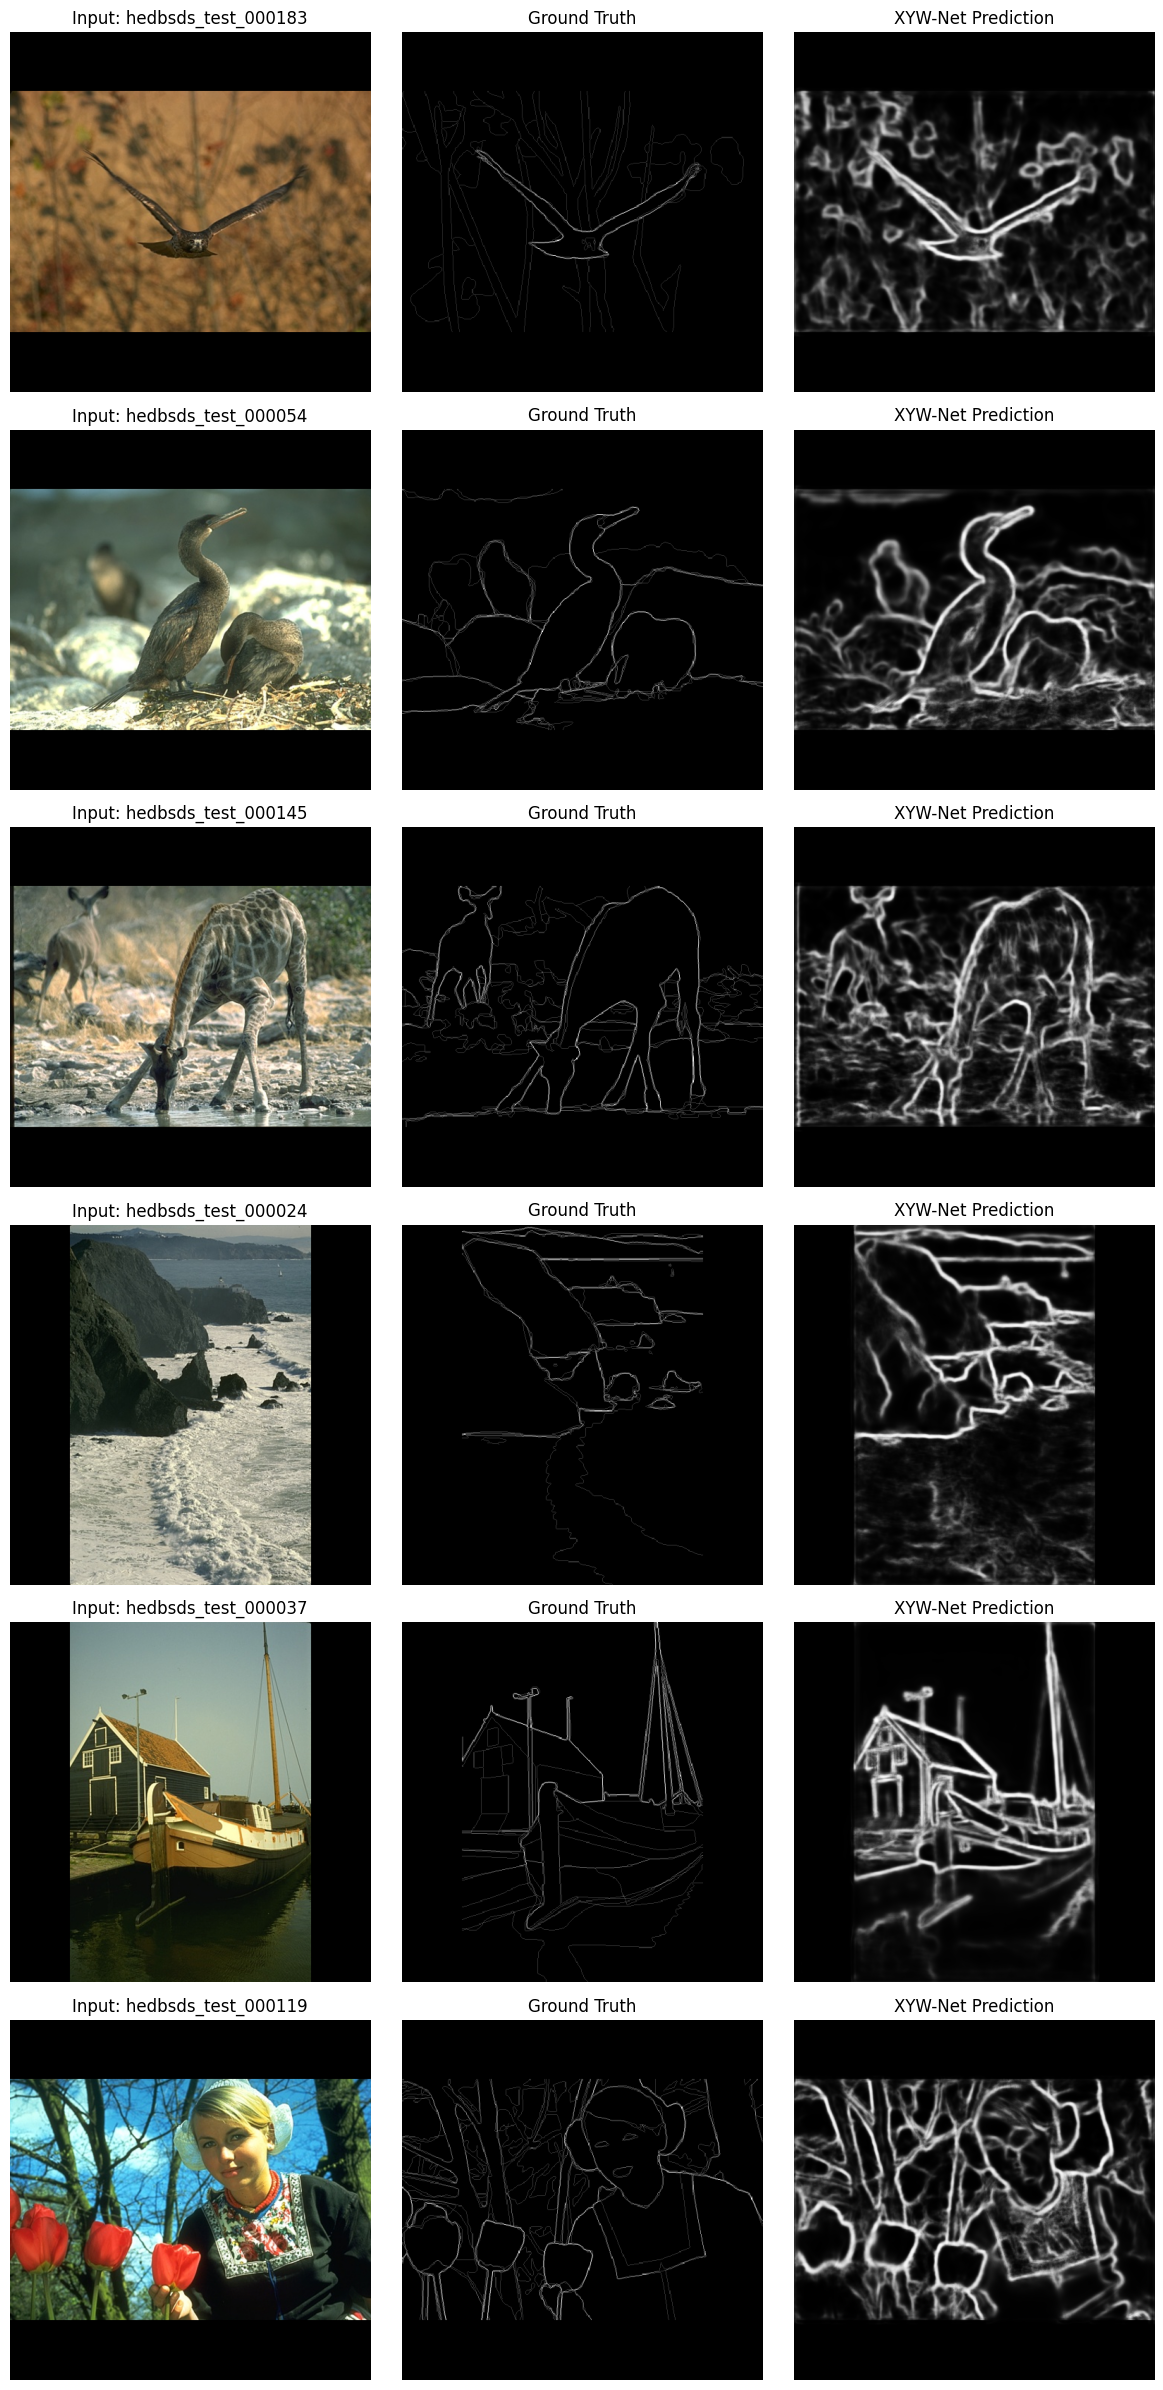

In [36]:
# Cell 9: Visualize Edge Predictions

@torch.no_grad()
def visualize_predictions(model, dataset, device, num_samples=6):
    """Visualize predictions on random samples"""
    model.eval()
    
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        img = sample['images'].unsqueeze(0).to(device)
        label = sample['labels'][0].numpy()
        
        pred = model(img)[0, 0].cpu().numpy()
        
        # Original image
        axes[i, 0].imshow(sample['images'].permute(1, 2, 0).numpy())
        axes[i, 0].set_title(f'Input: {sample["filename"]}')
        axes[i, 0].axis('off')
        
        # Ground truth
        axes[i, 1].imshow(label, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('XYW-Net Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150)
    plt.show()

visualize_predictions(model, test_dataset, device, num_samples=6)

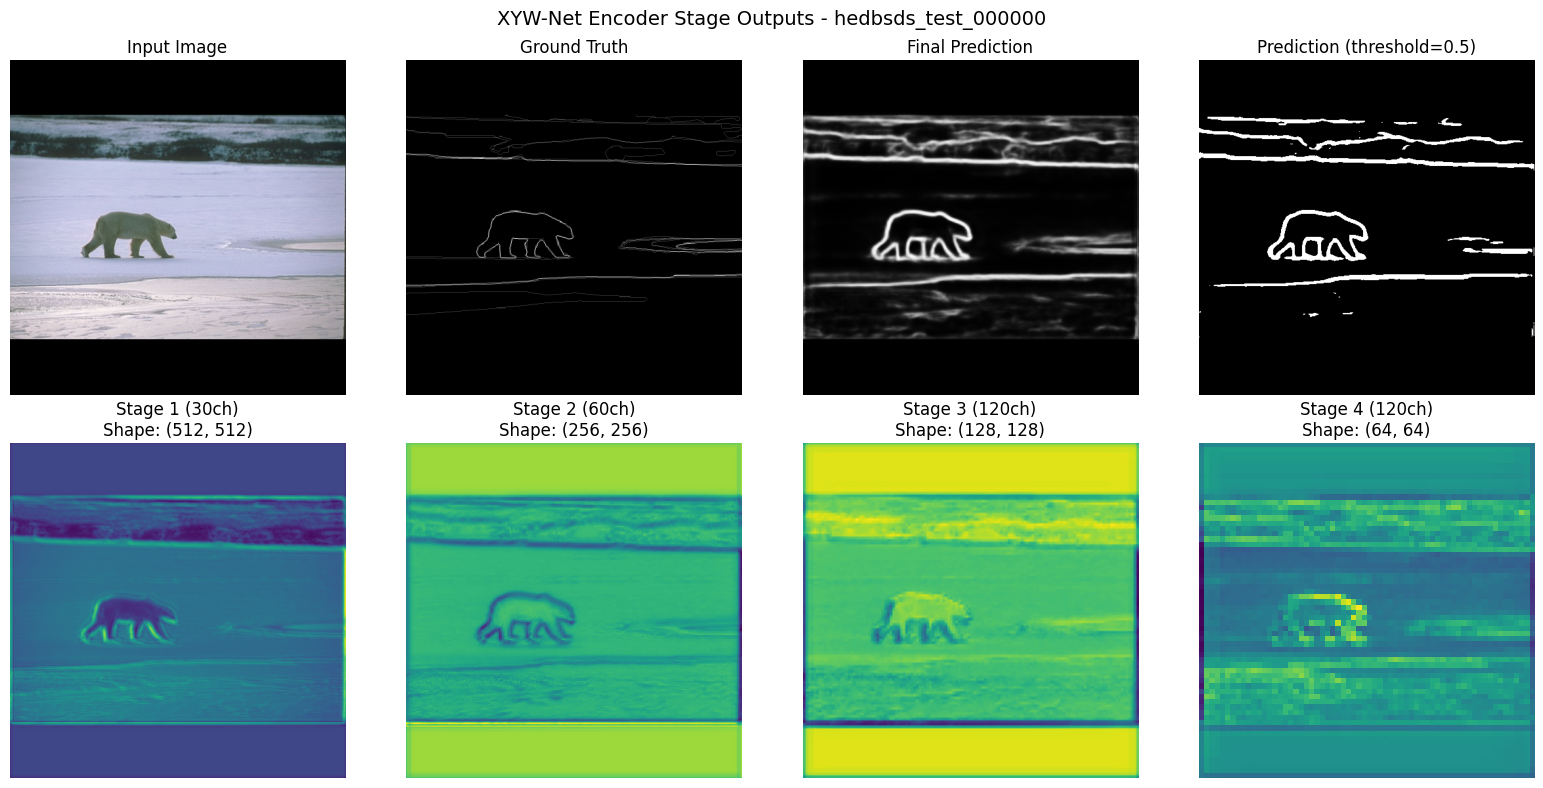

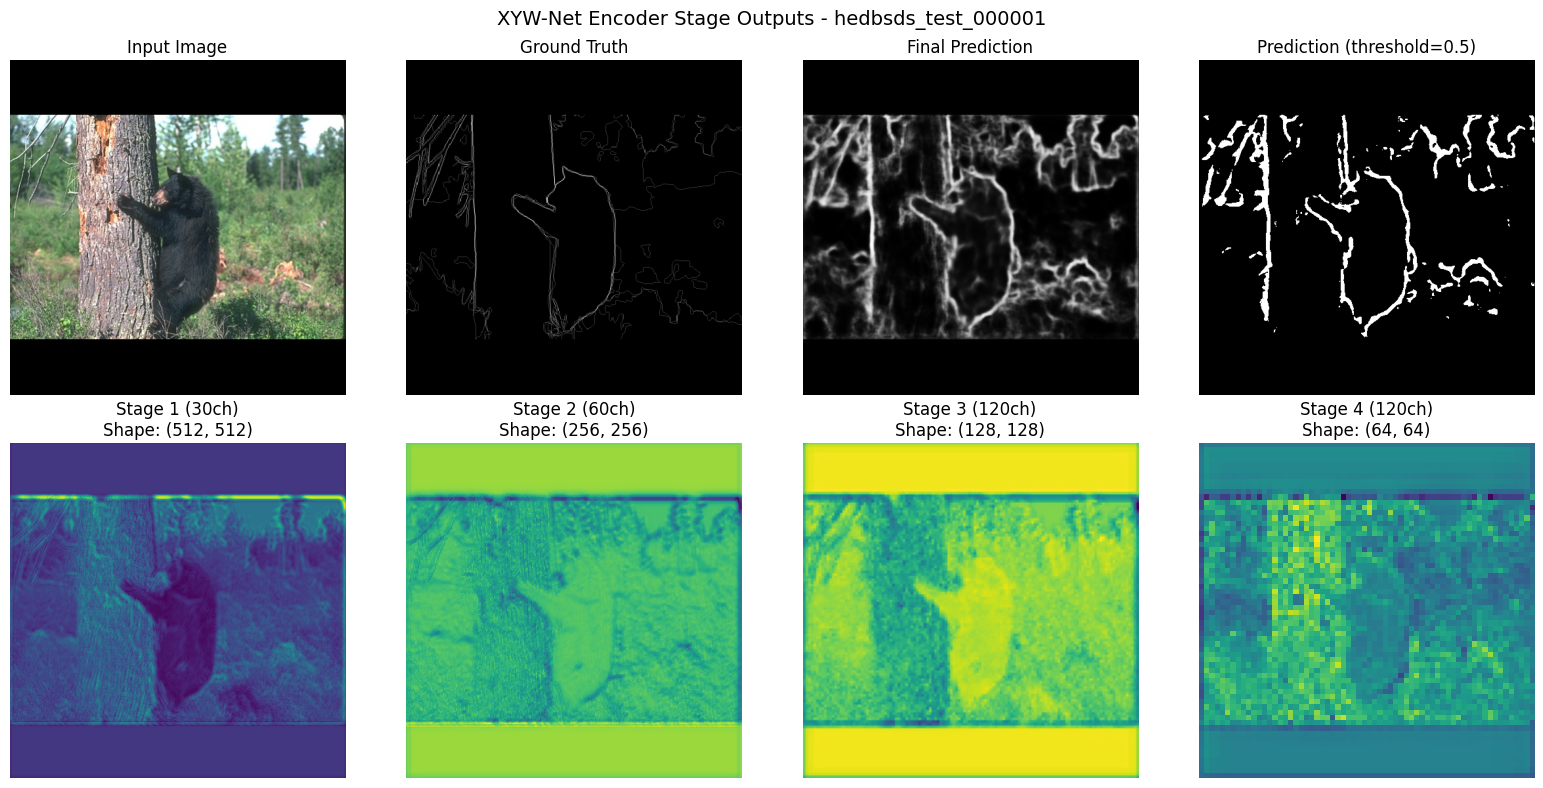

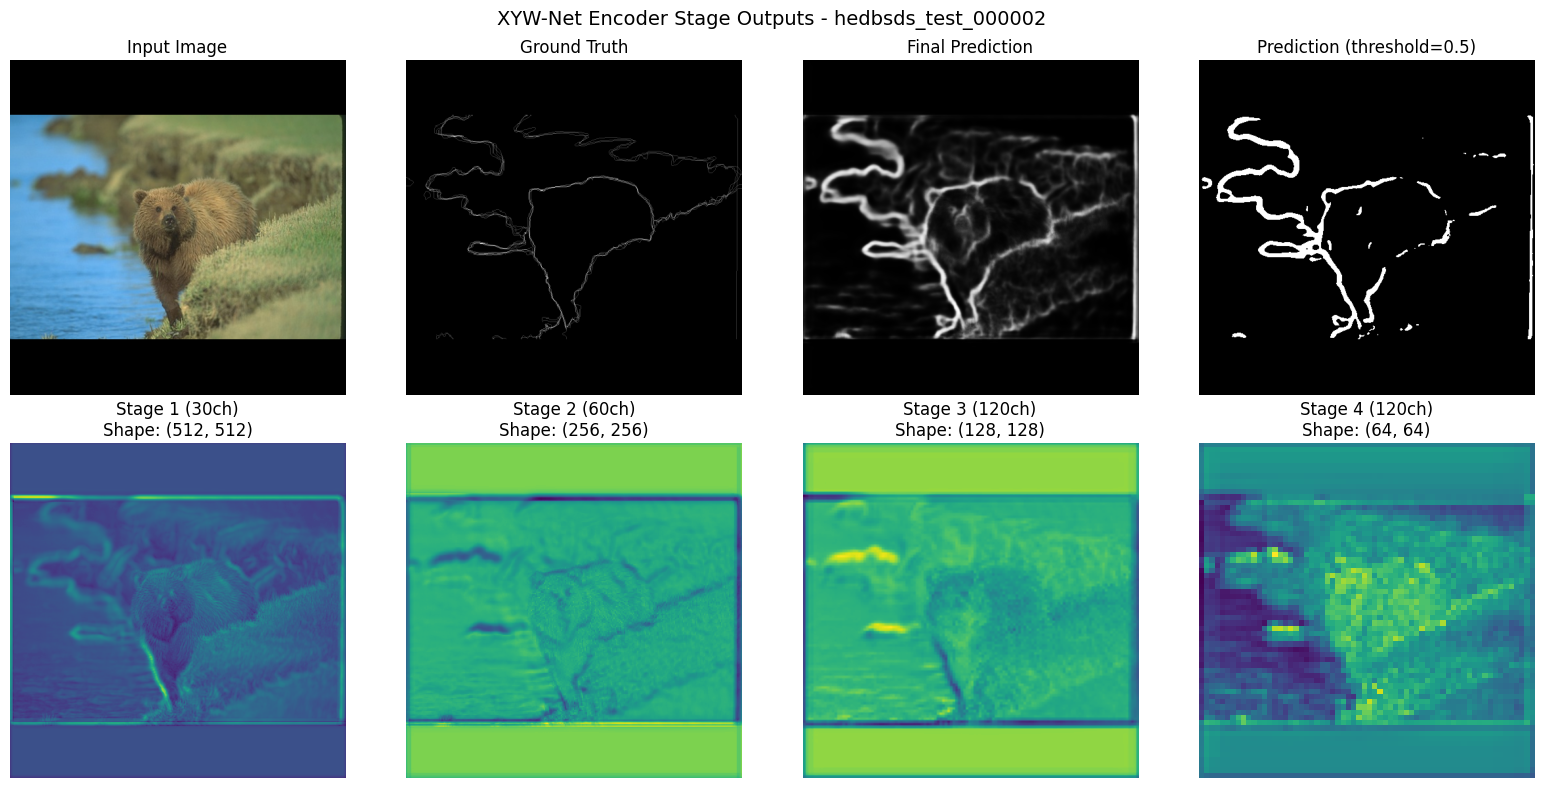

In [37]:
# Cell 10: Visualize Encoder Stage Outputs

@torch.no_grad()
def visualize_stages(model, dataset, device, sample_idx=0):
    """Visualize feature maps at each encoder stage"""
    model.eval()
    
    sample = dataset[sample_idx]
    img = sample['images'].unsqueeze(0).to(device)
    
    # Get stage outputs
    final, (s1, s2, s3, s4) = model.forward_with_stages(img)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Original image
    axes[0, 0].imshow(sample['images'].permute(1, 2, 0).numpy())
    axes[0, 0].set_title('Input Image')
    axes[0, 0].axis('off')
    
    # Ground truth
    axes[0, 1].imshow(sample['labels'][0].numpy(), cmap='gray')
    axes[0, 1].set_title('Ground Truth')
    axes[0, 1].axis('off')
    
    # Final prediction
    axes[0, 2].imshow(final[0, 0].cpu().numpy(), cmap='gray')
    axes[0, 2].set_title('Final Prediction')
    axes[0, 2].axis('off')
    
    # Thresholded prediction
    pred_binary = (final[0, 0].cpu().numpy() > 0.5).astype(float)
    axes[0, 3].imshow(pred_binary, cmap='gray')
    axes[0, 3].set_title('Prediction (threshold=0.5)')
    axes[0, 3].axis('off')
    
    # Stage feature maps (mean across channels)
    stages = [s1, s2, s3, s4]
    stage_names = ['Stage 1 (30ch)', 'Stage 2 (60ch)', 'Stage 3 (120ch)', 'Stage 4 (120ch)']
    
    for i, (stage, name) in enumerate(zip(stages, stage_names)):
        feat_mean = stage[0].mean(dim=0).cpu().numpy()
        feat_norm = (feat_mean - feat_mean.min()) / (feat_mean.max() - feat_mean.min() + 1e-8)
        axes[1, i].imshow(feat_norm, cmap='viridis')
        axes[1, i].set_title(f'{name}\nShape: {tuple(stage.shape[2:])}')
        axes[1, i].axis('off')
    
    plt.suptitle(f'XYW-Net Encoder Stage Outputs - {sample["filename"]}', fontsize=14)
    plt.tight_layout()
    plt.savefig('stage_outputs.png', dpi=150)
    plt.show()

# Visualize for a few samples
for idx in [0, 1, 2]:
    if idx < len(test_dataset):
        visualize_stages(model, test_dataset, device, sample_idx=idx)

Computing PR curve: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]


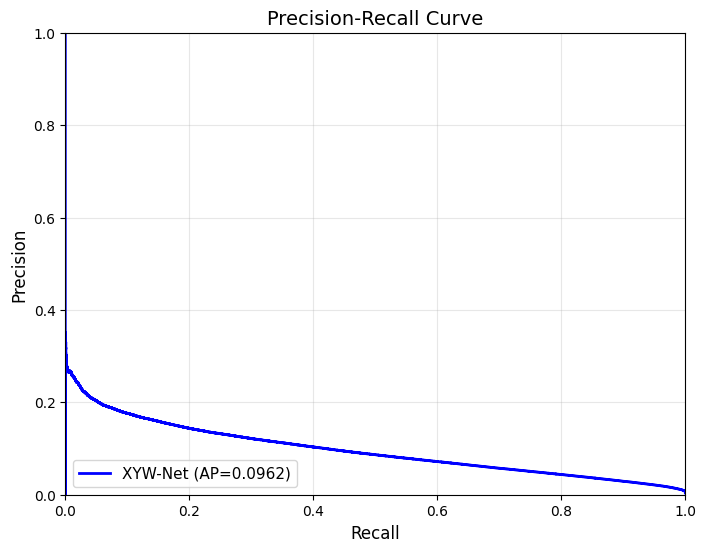

Average Precision: 0.0962


In [38]:
# Cell 11: Precision-Recall Curve

@torch.no_grad()
def plot_pr_curve(model, loader, device):
    """Plot precision-recall curve"""
    model.eval()
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc='Computing PR curve'):
        images = batch['images'].to(device)
        labels = batch['labels']
        outputs = model(images)
        
        for i in range(outputs.shape[0]):
            all_preds.append(outputs[i, 0].cpu().numpy().flatten())
            all_labels.append((labels[i, 0].numpy().flatten() > 0.5).astype(int))
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
    ap = average_precision_score(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, 'b-', linewidth=2, label=f'XYW-Net (AP={ap:.4f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.legend(loc='lower left', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.savefig('pr_curve.png', dpi=150)
    plt.show()
    
    return ap

ap = plot_pr_curve(model, test_loader, device)
print(f"Average Precision: {ap:.4f}")

In [ ]:
# Cell 12: Summary Results Table

print("\n" + "="*70)
print("                    XYW-NET EVALUATION SUMMARY")
print("="*70)
print(f"")
print(f"  Dataset:          {DATA_ROOT}")
print(f"  Train samples:    {len(train_dataset)}")
print(f"  Val samples:      {len(val_dataset)}")
print(f"  Test samples:     {len(test_dataset)}")
print(f"")
print(f"  Training epochs:  {NUM_EPOCHS}")
print(f"  Learning rate:    {LEARNING_RATE}")
print(f"  Batch size:       {BATCH_SIZE}")
print(f"")
print("  " + "-"*50)
print(f"  TEST SET METRICS:")
print("  " + "-"*50)
print(f"  ODS (Optimal Dataset Scale):   {test_ods:.4f}")
print(f"  OIS (Optimal Image Scale):     {test_ois:.4f}")
print(f"  AP (Average Precision):        {test_ap:.4f}")
print("="*70)
print(f"")
print("Saved files:")
print("  - best_xyw_net.pth      (model weights)")
print("  - training_history.png  (loss/metrics plot)")
print("  - predictions.png       (sample predictions)")
print("  - stage_outputs.png     (encoder stages)")
print("  - pr_curve.png          (precision-recall curve)")